In [1]:
# Importing the required packages
import igraph as ig
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats

# Specifying the figure parameters
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }
params = {'legend.fontsize': 16,
          'legend.handlelength': 2.}
plt.rcParams.update(params)

In [12]:
# Function for loading and merging the generated pickle files
def merge_files(name,iters):
    """retrieves and merges pickle files"""
    pt_all = []
    pc_all = []
    p_all = []
    h_all = []
    S_all = []
    I_all = []
    R_all = []
    cl_all = []
    t_all = []
    for i in range(iters):
        with open(name.format(i),'rb') as f:
            pt, pc, cl, t, p, h, S, I, R = pickle.load(f)
            pt_all = pt_all + pt
            pc_all = pc_all + pc
            p_all = p_all + p
            h_all = h_all + h
            S_all =  S_all + S
            I_all = I_all + I
            R_all = R_all + R
            cl_all = cl_all + cl
            t_all = t_all + t
    return pt_all, pc_all, cl_all, t_all, p_all, h_all, S_all, I_all, R_all

# Function for plotting a new set of simulations
def plot_results(iters=100,pop=10000,setseed=3,edge_per_node=2,infect_len=5,days=170,
                 mitigation=False,m=8,probs_inf=[0.01,0.01,0.1,0.2,0.3,0.3,0.3,0.25,0.2,0.15,0.1,0.05,0.01,0.01],
                 mitigation2=False,m2=100):
    """plots the SIR model outcomes of the specified network"""
    nb_S_all = []
    nb_I_all = []
    nb_R_all = []
    for i in range(0,iters):
        setseed = setseed+1
        g = ig.Graph.Barabasi(pop, edge_per_node,power=1)
        if mitigation is True:
            max_connect(g,m) # limits the maximum number of neighbors to m
        if mitigation2 is True:
            remove_edg(g,m2) # randomly removes m2 edges from the network
        g.vs["state"] = "S"
        g.vs["duration"] = 0
        i = rd.randint(0, pop-1)
        g.vs[i]["state"] = "I"
        nb_S = [pop]
        nb_I = [1]
        nb_R = [0]
        for time in range(days): #no. of days
            for n in g.vs.select(state_eq = "I"): #iterates through each node in the network
                g.vs[n.index]["duration"] += 1 #from day 0 to infect_len this node continues to infect
                day_inf = g.vs[n.index]["duration"]
                for nb in g.neighbors(n): #iterates through neighbours of that node
                    if g.vs[nb]["state"] == "S": #if node is infected...
                        r = rd.random() #random state
                        if r < probs_inf[day_inf]:
                            g.vs[nb]["state"] = "I" #change state to infected
                if g.vs[n.index]["duration"] >= rd.randrange(2,14): #after infect_len that node changes to recovered
                    g.vs[n.index]["state"] = "R"
            nb_S.append(len(g.vs.select(state_eq = "S"))) #no. of susceptibles in population
            nb_I.append(len(g.vs.select(state_eq = "I"))) #no. of infecteds in population
            nb_R.append(len(g.vs.select(state_eq = "R"))) #no. of recovereds in population
        nb_S_all.append(nb_S)
        nb_I_all.append(nb_I)
        nb_R_all.append(nb_R)
    return nb_S_all, nb_I_all, nb_R_all

def max_connect(g,m):
    """randomly removes edges for nodes that have more than m connections"""
    no_edge_rm = 0
    for n in g.vs:
        if n.degree() > m:
            nlist = g.neighbors(n)
            nremove = n.degree()-m
            nlistremove = rd.sample(nlist, k=nremove)
            no_edge_rm = no_edge_rm + nremove
            for i in nlistremove:
                g.delete_edges(g.es[g.get_eid(i, n)])
    return no_edge_rm

def remove_edg(g,m):
    """randomly removes m edges from a network g"""
    edg_rm = rd.sample(range(len(g.es)), k=m)
    g.delete_edges(edg_rm)

In [4]:
# Retrieving the picke files and merging them into a single list
pt, pc, cl, t, p, h, S, I, R =  merge_files('SIR{}.pickle',50)
pt_m, pc_m, cl_m, t_m, p_m, h_m, S_m, I_m, R_m = merge_files('SIR{}_M.pickle',50)
pt_m2, pc_m2, cl_m2, t_m2, p_m2, h_m2, S_m2, I_m2, R_m2 = merge_files('SIR{}_M2.pickle',50)

In [0]:
# Testing for Normality in the Parameter Distributions
for l in [pt, pt_m, pt_m2, t, t_m, t_m2]:
    k2, p = stats.normaltest(l)
    print(p)

# Statistical Comparison Between Distributions
p1 = stats.kruskal(t,t_m)
print(p1)
p2 = stats.kruskal(t,t_m2)
print(p2)
p3 = stats.kruskal(pt,pt_m)
print(p3)
p4 = stats.kruskal(pt,pt_m2)
print(p4)

Text(0.93, 0.93, '(B)')

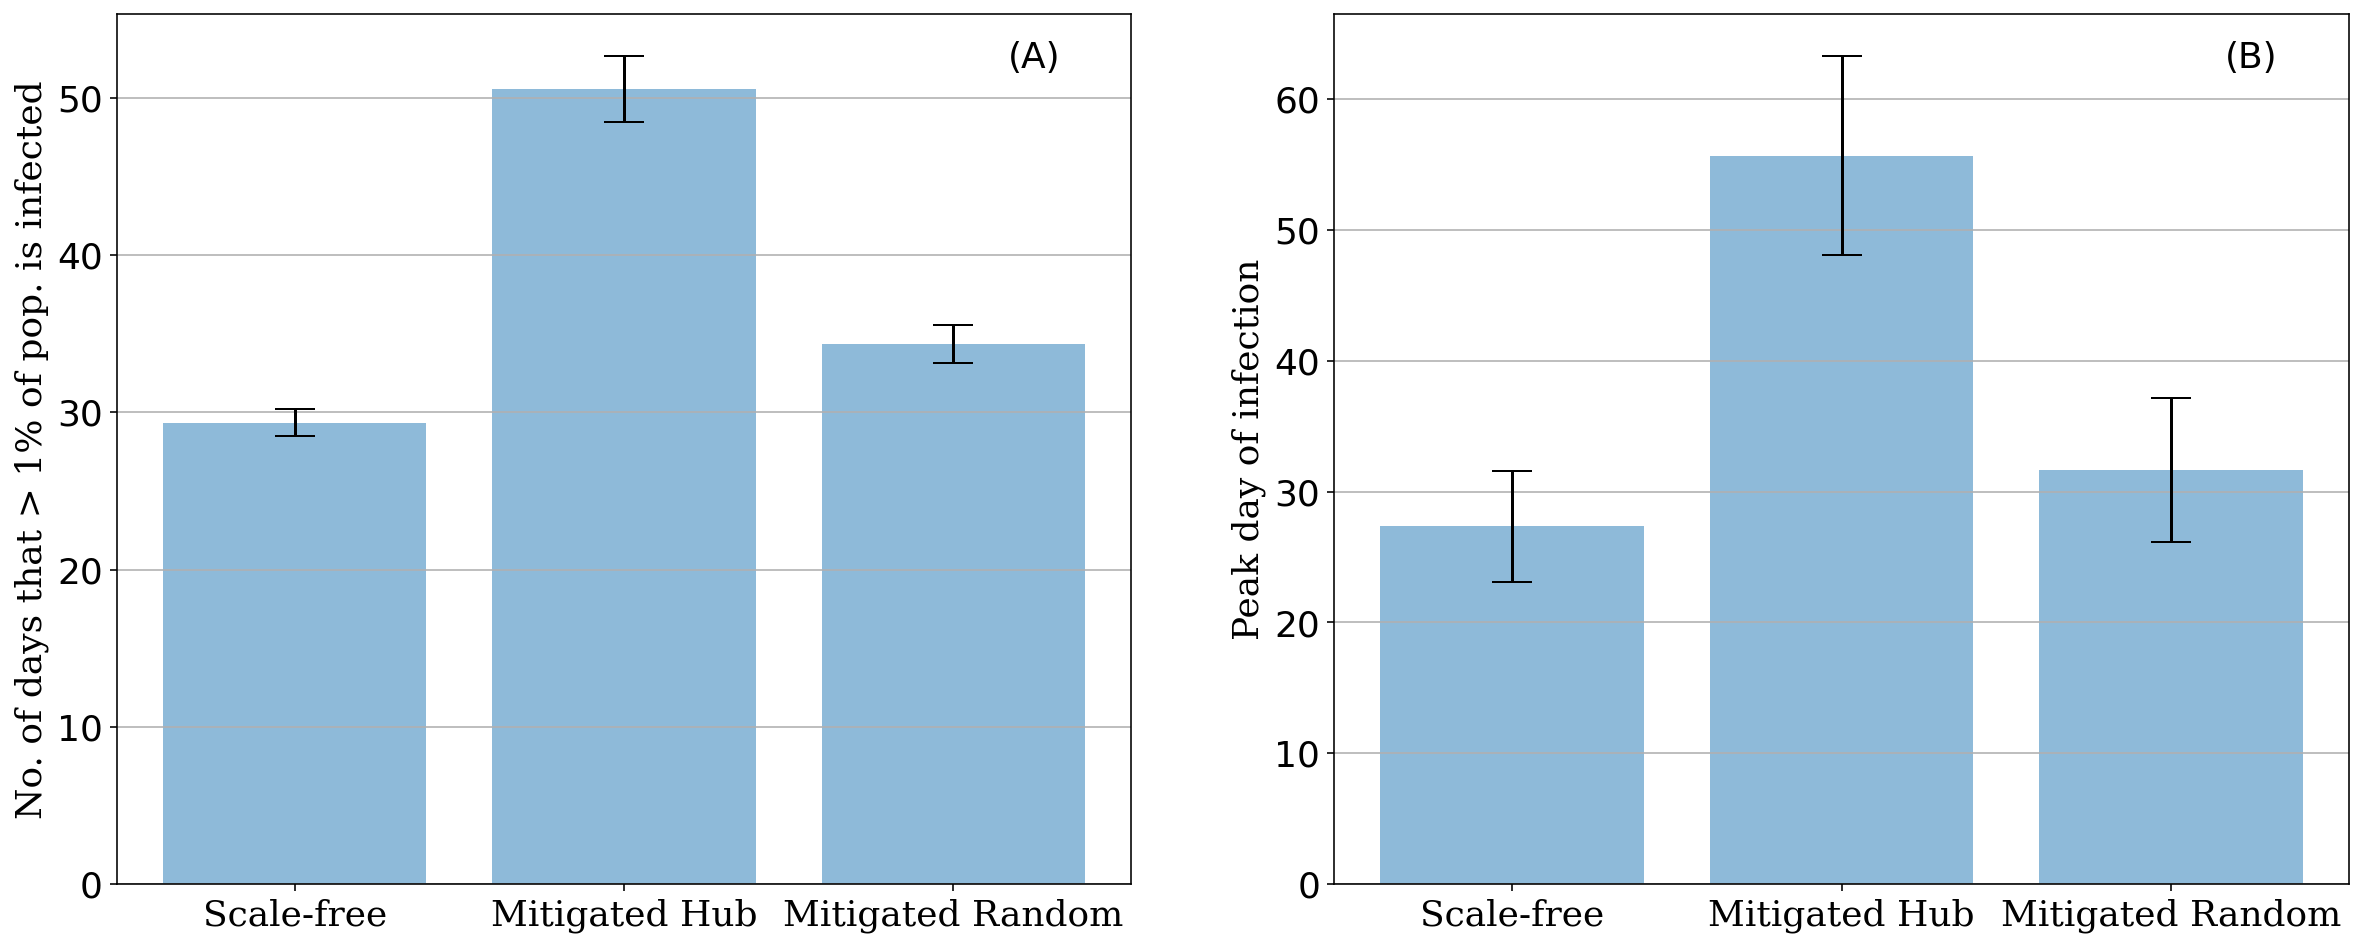

In [5]:
# Plotting the time that > 1% of the population is infected
fig,(ax, ax2) = plt.subplots(1, 2, figsize=(20,8))
times = [np.mean(t),np.mean(t_m),np.mean(t_m2)]
labels = ["Scale-free", "Mitigated Hub", "Mitigated Random"]
error = [np.std(t),np.std(t_m),np.std(t_m2)]
x_pos = np.arange(len(times))
ax.bar(x_pos, times,yerr=error, align='center', alpha=0.5, ecolor='black',capsize=10)
ax.set_ylabel('No. of days that > 1% of pop. is infected',fontdict=font)
ax.set_xticks(x_pos)
ax.tick_params(axis='both', labelsize=18)
ax.set_xticklabels(labels,fontdict=font)
ax.yaxis.grid(True)
ax.text(0.93, 0.93, '(A)',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,fontsize=18)

# Plotting the day at which the peak occurs
times = [np.mean(pt),np.mean(pt_m),np.mean(pt_m2)]
labels = ["Scale-free", "Mitigated Hub", "Mitigated Random"]
error = [np.std(pt),np.std(pt_m),np.std(pt_m2)]
x_pos = np.arange(len(times))
ax2.bar(x_pos, times,yerr=error, align='center', alpha=0.5, ecolor='black',capsize=10)
ax2.set_ylabel('Peak day of infection',fontdict=font)
ax2.set_xticks(x_pos)
ax2.tick_params(axis='both', labelsize=18)
ax2.set_xticklabels(labels,fontdict=font)
ax2.yaxis.grid(True)
ax2.text(0.93, 0.93, '(B)',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,fontsize=18)

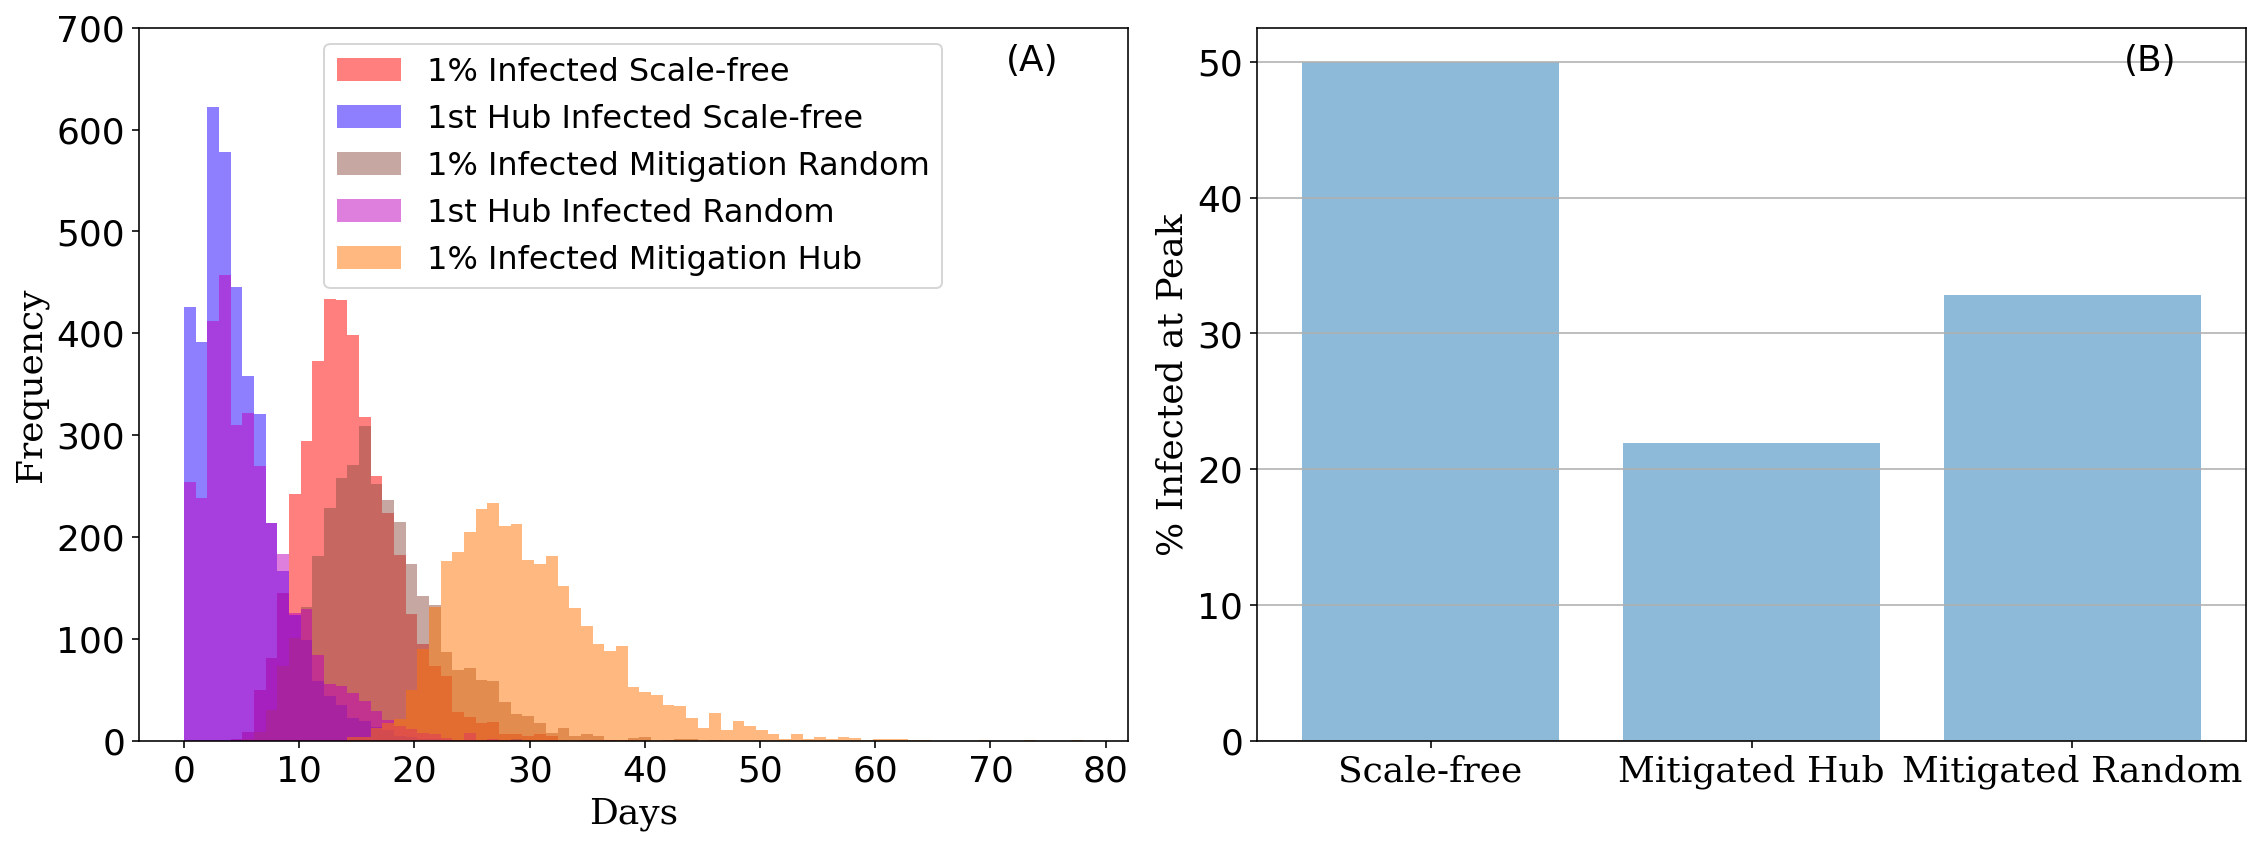

In [6]:
# Plotting the % population infected at the peak
fig,(ax2, ax) = plt.subplots(1, 2, figsize=(16,6))
times = [np.mean(pc),np.mean(pc_m),np.mean(pc_m2)]/np.mean(R)*100
labels = ["Scale-free", "Mitigated Hub", "Mitigated Random"]
x_pos = np.arange(len(times))
ax.bar(x_pos, times, align='center', alpha=0.5, ecolor='black')
ax.set_ylabel('% Infected at Peak',fontdict=font)
ax.set_xticks(x_pos)
ax.tick_params(axis='both', labelsize=18)
ax.set_xticklabels(labels,fontdict=font)
ax.yaxis.grid(True)
ax.text(0.93, 0.93, '(B)',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,fontsize=18)

# Plotting the time of the first 1% getting infected
# and the time of the first hub getting infected (scale-free only)
bins = np.linspace(min(h+p),max(h+p_m),78)
h1 = ax2.hist(p,bins,alpha=0.5,facecolor='r')
h2 = ax2.hist(h,bins,alpha=0.5,facecolor='#1F00FF')
h1 = ax2.hist(p_m2,bins,alpha=0.5,facecolor='#915045')
h2 = ax2.hist(h_m2,bins,alpha=0.5,facecolor='m')
h1 = ax2.hist(p_m,bins,alpha=0.5,facecolor='#FF7200')
ax2.legend(loc='upper center',labels=["1% Infected Scale-free","1st Hub Infected Scale-free","1% Infected Mitigation Random","1st Hub Infected Random","1% Infected Mitigation Hub"])
ax2.tick_params(axis='both', labelsize=18)
ax2.set_xlabel("Days",fontdict=font)
ax2.set_ylabel("Frequency",fontdict=font)
ax2.set_ylim([0, 700])
ax2.text(0.93, 0.93, '(A)',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,fontsize=18)

fig.tight_layout()

(0.0, 4000.0)

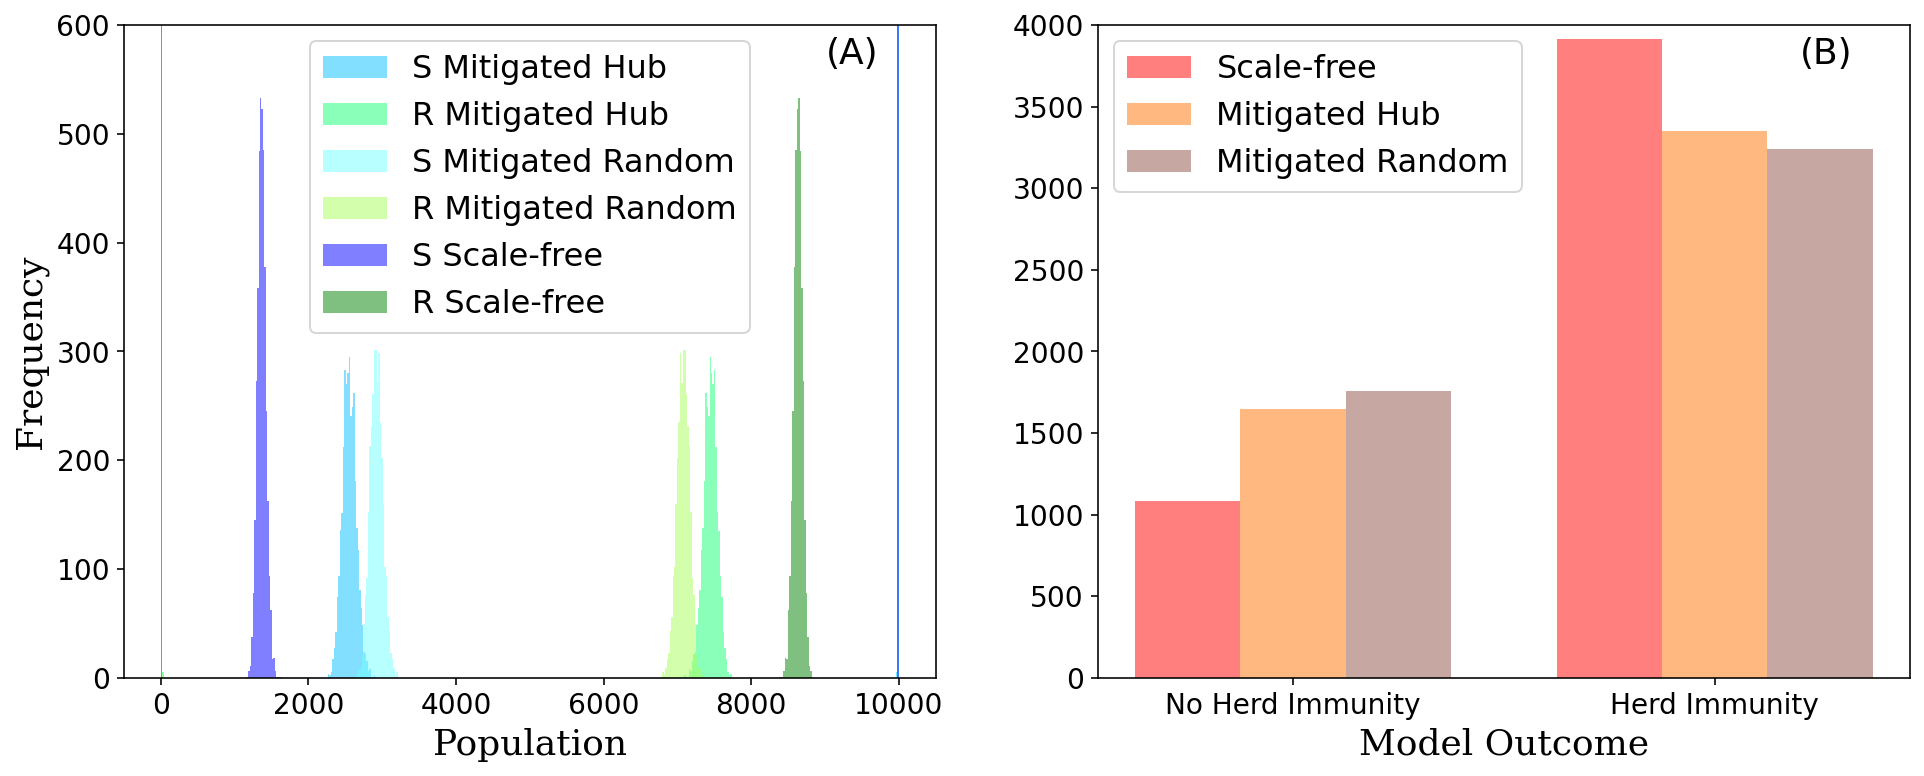

In [7]:
# Plotting the final model outcomes
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
bins = np.linspace(0,10000,500)
h1 = ax1.hist(S_m,bins,alpha=0.5,facecolor='#08C0FF')
h2 = ax1.hist(R_m,bins,alpha=0.5,facecolor='#16FF76')
h1 = ax1.hist(S_m2,bins,alpha=0.5,facecolor='#73FFFF')
h2 = ax1.hist(R_m2,bins,alpha=0.5,facecolor='#A8FF5B')
h1 = ax1.hist(S,bins,alpha=0.5,facecolor='b')
h2 = ax1.hist(R,bins,alpha=0.5,facecolor='g')
ax1.legend(loc='upper center',labels=["S Mitigated Hub","R Mitigated Hub","S Mitigated Random","R Mitigated Random","S Scale-free","R Scale-free"])
ax1.tick_params(axis='both', labelsize=14)
ax1.set_xlabel("Population",fontdict=font)
ax1.set_ylabel("Frequency",fontdict=font)
ax1.set_ylim([0,600])
ax1.text(0.93, 0.93, '(A)',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,fontsize=18)

# Plotting the two possible model solutions
labels = ['No Herd Immunity', 'Herd Immunity']
standard = [sum([s>9900 for s in S]), sum([s<9900 for s in S])]
mitigated = [sum([s>9900 for s in S_m]), sum([s<9900 for s in S_m])]
mitigatedR = [sum([s>9900 for s in S_m2]), sum([s<9900 for s in S_m2])]
width = 0.25  # the width of the bars
r1 = np.arange(len(labels))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
rects1 = ax2.bar(r1, standard, width, label='Scale-free',facecolor='r',alpha=0.5)
rects2 = ax2.bar(r2, mitigated, width, label='Mitigated Hub',facecolor='#FF7200',alpha=0.5)
rects3 = ax2.bar(r3, mitigatedR, width, label='Mitigated Random',facecolor='#915045',alpha=0.5)
plt.xticks([r + width for r in range(len(labels))], labels)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_xlabel("Model Outcome",fontdict=font)
ax2.legend(loc='upper left')
ax2.text(0.93, 0.93, '(B)',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,fontsize=18)
ax2.set_ylim([0,4000])

(20.0, 75.0)

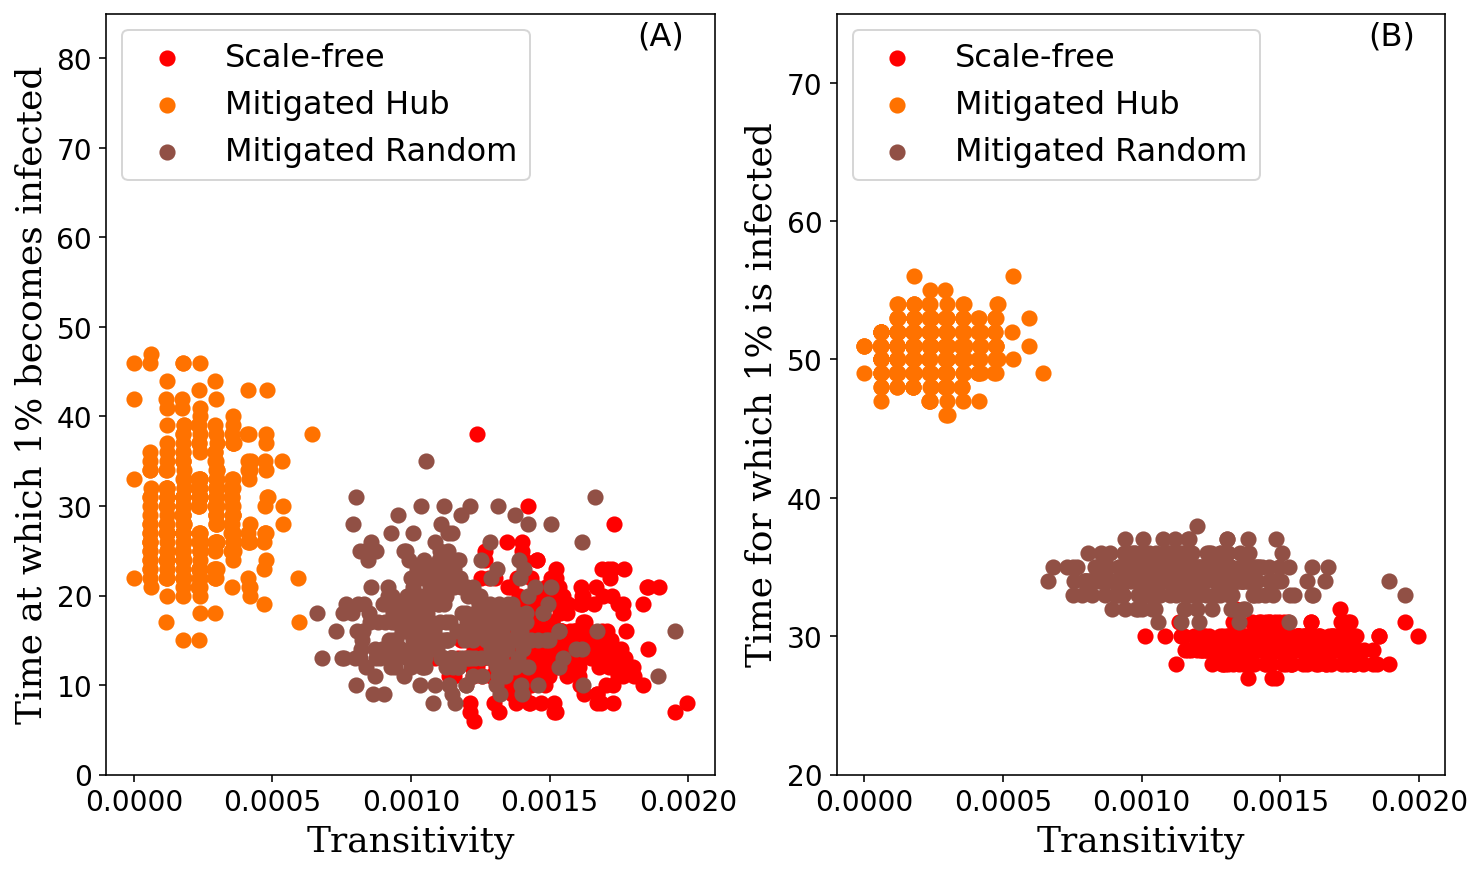

In [8]:
# Correlating clustering with the time at which 1% becomes infected
smpl = 300
alph=1
x = rd.sample(range(min(len(t),len(t_m),len(t_m2))),k=smpl)
fig,(ax1, ax2) = plt.subplots(1, 2)
pointsize = 50
ax1.scatter([cl[i] for i in x] ,[p[i] for i in x],color='r',s=pointsize,alpha=alph)
ax1.scatter([cl_m[i] for i in x] ,[p_m[i] for i in x],color='#FF7200',s=pointsize,alpha=alph)
ax1.scatter([cl_m2[i] for i in x] ,[p_m2[i] for i in x],color='#915045',s=pointsize,alpha=alph)
ax1.legend(loc='upper left',labels=["Scale-free","Mitigated Hub","Mitigated Random"])
ax1.tick_params(axis='both', labelsize=14)
ax1.set_xlabel("Transitivity",fontdict=font)
ax1.set_ylabel("Time at which 1% becomes infected",fontdict=font)
ax1.text(0.95, 0.95, '(A)',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,fontsize=16)
ax1.set_ylim([0,85])

# Correlating clustering with the total time for which 1% is infected
ax2.scatter([cl[i] for i in x] ,[t[i] for i in x],color='r',label='Scale-free',s=pointsize,alpha=alph)
ax2.scatter([cl_m[i] for i in x] ,[t_m[i] for i in x],color='#FF7200',label='Mitigated Hub',s=pointsize,alpha=alph)
ax2.scatter([cl_m2[i] for i in x] ,[t_m2[i] for i in x],color='#915045',label='Mitigated Random',s=pointsize,alpha=alph)
ax2.legend(loc='upper left')
ax2.tick_params(axis='both', labelsize=14)
ax2.set_xlabel("Transitivity",fontdict=font)
ax2.set_ylabel("Time for which 1% is infected",fontdict=font)
ax2.text(0.95, 0.95, '(B)',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,fontsize=16)
ax2.set_ylim([20,75])

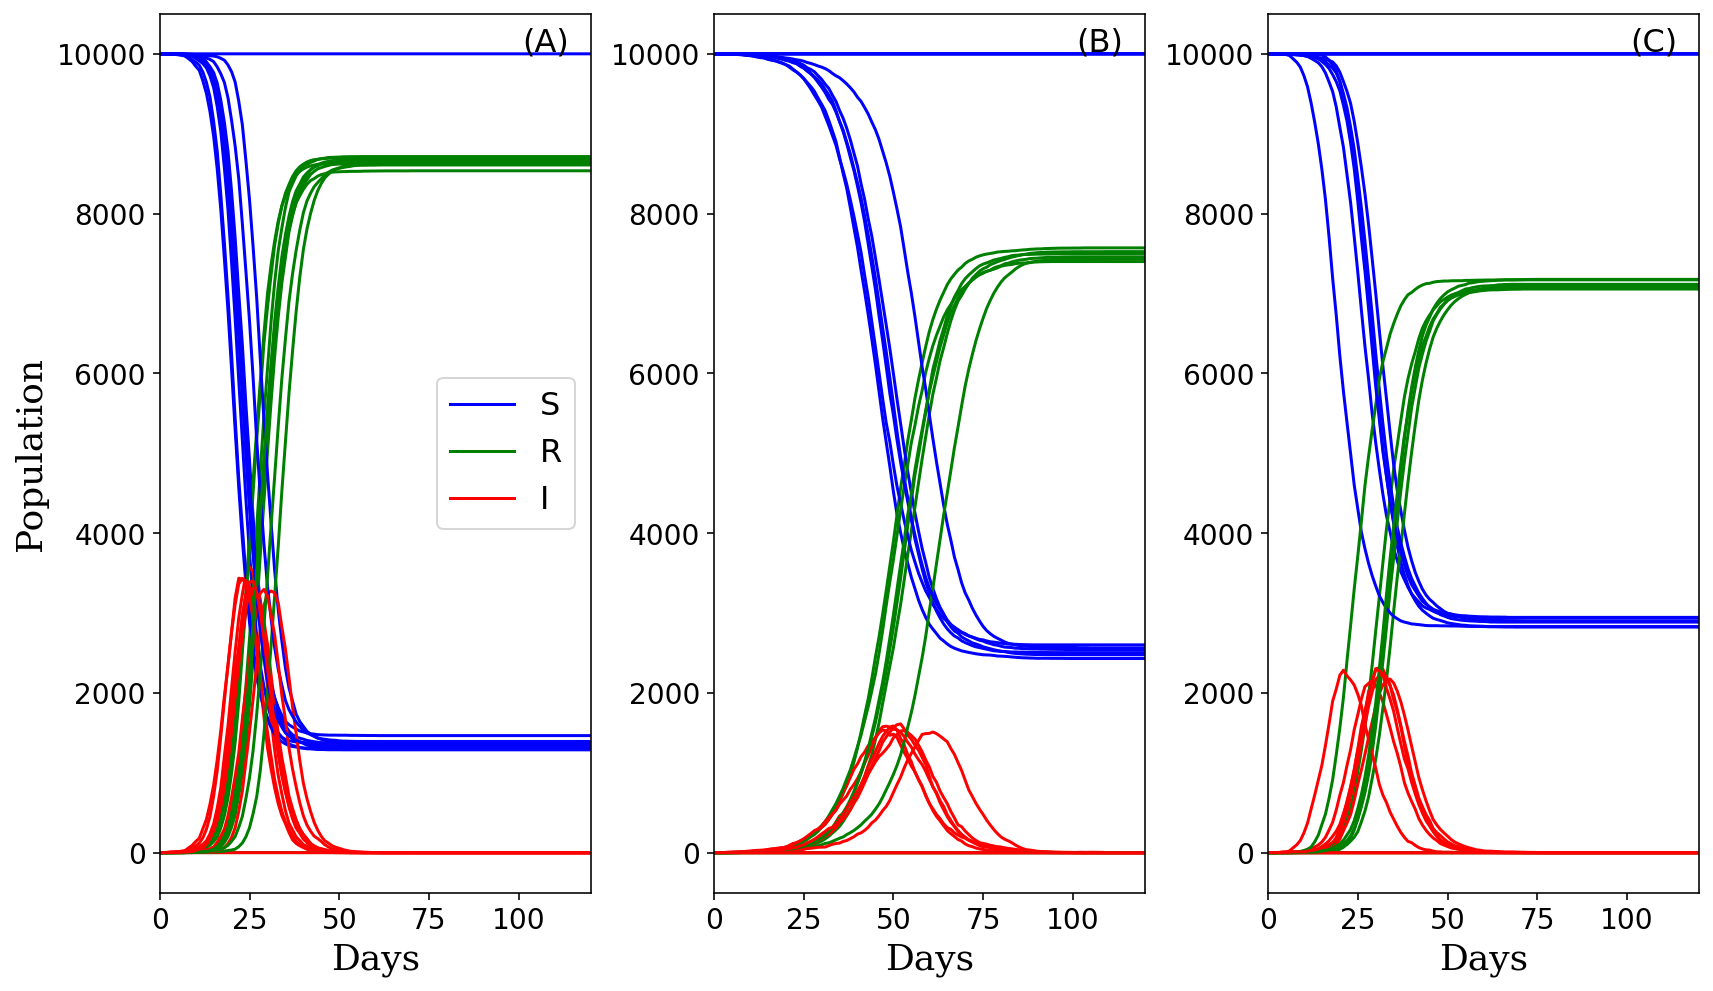

In [14]:
# Plotting the change in population over time for the 3 networks
# SIR model
ds = 120
its = 10
nS, nI, nR = plot_results(iters=its,days=ds)
nS_m, nI_m, nR_m = plot_results(iters=its,mitigation=True,m=8,days=ds)
nS_m2, nI_m2, nR_m2 = plot_results(iters=its,mitigation2=True,m2=4605,days=ds)

fig,(ax1, ax2, ax3) = plt.subplots(1, 3)

# Scale-free
for i in range(len(nS)):
    line1 = ax1.plot(nS[i], 'b-', label='S')
    line2 = ax1.plot(nR[i], 'g-', label='R')
    line3 = ax1.plot(nI[i], 'r-', label='I')
ax1.set_xlabel("Days",fontdict=font)
ax1.tick_params(axis='both', labelsize=14)
ax1.set_xlim([0,ds])
ax1.text(0.95, 0.95, '(A)',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,fontsize=16)
ax1.set_ylabel("Population",fontdict=font)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:3],labels[:3])

# Mitigation Hub
for i in range(len(nS_m)):
    line1 = ax2.plot(nS_m[i], 'b-', label='S')
    line2 = ax2.plot(nR_m[i], 'g-', label='R')
    line3 = ax2.plot(nI_m[i], 'r-', label='I')
ax2.set_xlabel("Days",fontdict=font)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_xlim([0,ds])
ax2.text(0.95, 0.95, '(B)',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,fontsize=16)

# Mitigation Random
for i in range(len(nS_m)):
    line1 = ax3.plot(nS_m2[i], 'b-', label='S')
    line2 = ax3.plot(nR_m2[i], 'g-', label='R')
    line3 = ax3.plot(nI_m2[i], 'r-', label='I')
ax3.set_xlabel("Days",fontdict=font)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim([0,ds])
ax3.text(0.95, 0.95, '(C)',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,fontsize=16)

fig.tight_layout()